In [2]:
!pip install pandas
!pip install numpy
!pip install keras
import types
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
df_data_1 =pd.DataFrame(pd.read_csv("./DCOILBRENTEU.csv"))
df_data_1.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(8587, 2)


In [5]:
!pip install matplotlib
import matplotlib.pyplot as plt
df_data_1.iloc[:,1:2]=df_data_1.iloc[:,1:2].values.astype(np.float)
df_data_1_plot = df_data_1.iloc[:,1:2].values
df_data_1_plot
# Visualising the Data

array([[18.63],
       [18.45],
       [18.55],
       ...,
       [69.34],
       [68.87],
       [68.78]], dtype=object)

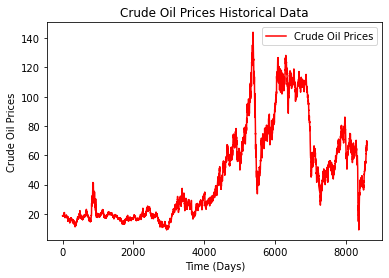

In [6]:
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [7]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 200
timesteps = 30

In [8]:
length = len(df_data_1)
print(length)

#test set will be 10% of entire data set  
#length *= 1 - 0.1
#print(length)

8587


In [9]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [10]:
length = get_train_length(df_data_1, batch_size, 0.1)
#print(length)

7680


In [11]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(7740, 1)

In [12]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7740, 1)

In [13]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len (y_train))
print(np.array(X_train).shape)
print(np.array(y_train).shape)

7710
7680
7680
(7680, 30)
(7680, 30)


In [14]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(7680, 30, 1)
(7680, 30, 1)


In [15]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.layers import Dropout
from keras.models import Model
import h5py

In [16]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
#dropout_1=Dropout(0.5)(lstm_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [18]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [19]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0

Epoch 1/1
7680/7680 [==============================] - 4s 506us/step - loss: 0.0599
Epoch: 1
Epoch 1/1
7680/7680 [==============================] - 3s 413us/step - loss: 0.0608
Epoch: 2
Epoch 1/1
7680/7680 [==============================] - 3s 419us/step - loss: 0.0723
Epoch: 3
Epoch 1/1
7680/7680 [==============================] - 4s 526us/step - loss: 0.0912
Epoch: 4
Epoch 1/1
7680/7680 [==============================] - 4s 502us/step - loss: 0.0823
Epoch: 5
Epoch 1/1
7680/7680 [==============================] - 3s 411us/step - loss: 0.0824
Epoch: 6
Epoch 1/1
7680/7680 [==============================] - 3s 408us/step - loss: 0.0736
Epoch: 7
Epoch 1/1
7680/7680 [==============================] - 4s 471us/step - loss: 0.0686
Epoch: 8
Epoch 1/1
7680/7680 [==============================] - 4s 526us/step - loss: 0.0643
Epoch: 9
Epoch 1/1
7680/7680 [==============================] - 3s 440us/step - loss: 0.0593
Epoch: 10
Epoch 1/1
7680/7680 [==============================] - 4s 5

/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


7680/7680 [==============================] - 10s 1ms/step - loss: 0.0343
Epoch: 126
Epoch 1/1
7680/7680 [==============================] - 6s 756us/step - loss: 0.0343
Epoch: 127
Epoch 1/1
7680/7680 [==============================] - 4s 511us/step - loss: 0.0343
Epoch: 128
Epoch 1/1
7680/7680 [==============================] - 3s 454us/step - loss: 0.0344
Epoch: 129
Epoch 1/1
7680/7680 [==============================] - 4s 489us/step - loss: 0.0343
Epoch: 130
Epoch 1/1
7680/7680 [==============================] - 5s 631us/step - loss: 0.0344
Epoch: 131
Epoch 1/1
7680/7680 [==============================] - 4s 457us/step - loss: 0.0342
Epoch: 132
Epoch 1/1
7680/7680 [==============================] - 3s 450us/step - loss: 0.0343
Epoch: 133
Epoch 1/1
7680/7680 [==============================] - 8s 1ms/step - loss: 0.0342
Epoch: 134
Epoch 1/1
7680/7680 [==============================] - 5s 607us/step - loss: 0.0341
Epoch: 135
Epoch 1/1
7680/7680 [==============================] - 4s 540us

In [20]:
!pwd
!ls models/*.h5

/Users/penghui/FE5225/project/baseline
models/my_model_with_mae_30_ts.h5


In [21]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [22]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

8444
8508
8508
768


In [23]:
print(upper_train, upper_test, len(df_data_1))

7740 8568 8587


In [24]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(768, 30, 1)
(768, 30)
(738, 1)


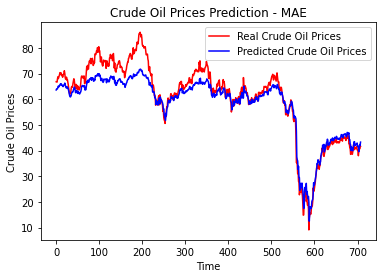

In [26]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [27]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

4.4841142239567775


In [28]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

3.3460338852230445


In [29]:
import h5py
regressor_mae.save(filepath="models/my_model_with_mae_30_ts.h5")